In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy
astropy.__version__

'5.1'

In [3]:
%matplotlib inline
from astropy import units as u
from astropy.cosmology import Planck18
from astropy.table import Table, join
import cmasher as cmr
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

pip installable:

In [4]:
import profiley
profiley.__version__

'1.3.4b'

In [5]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from plottery.plotutils import savefig, update_rcParams
from profiley.nfw import NFW
update_rcParams()

/home/cristobal/anaconda3/envs/bluemembers/lib/python3.10/site-packages/plottery/plotutils.py:175: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams[key] = default[key]


My own code, at https://github.com/cristobal-sifon/astro

In [6]:
from astro.clusters import catalogs, conversions

In [7]:
catalogs.list_available()

Available catalogs:
('abell', 'actpol', 'advact', 'gmbcg', 'hecs2013', 'madcows', 'maxbcg', 'mcxc', 'orca', 'psz1', 'psz2', 'redmapper', 'spt-sz', 'whl')


In [74]:
sample = 'lowz'
sample = 'evolution'

In [75]:
chances = Table.read(f'catalogues/chances_clusters_{sample}_all.txt', format='ascii.fixed_width')
if sample == 'lowz':
    chances.rename_column('name', 'CHANCES name')
chances

CHANCES name,VISTA,Comments,name,index,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT
str19,str4,str17,str19,int64,int64,str10,str9,float64,float64,float64,float64,str10,str9,float64,float64,float64,float64,int64,str19,str10,str9,float64,float64,float64,float64
PSZ2 G304.84-41.40,SMC,--,PSZ2 G304.84-41.40,--,--,00:28:16.7,-75:38:02,0.41,7.65,0.38,0.35,00:28:16.7,-75:38:02,0.41,7.65,0.38,0.35,--,--,--,--,--,--,--,--
Abell0907,HiLx,--,PSZ2 G249.38+33.26,--,--,09:58:24.4,-11:04:08,0.167,5.41,0.37,0.33,09:58:24.4,-11:04:08,0.17,5.41,0.37,0.33,--,--,--,--,--,--,--,--
Abell0901,HiLx,--,--,--,--,09:56:26.4,-10:04:12,0.163,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
RXC J0600.1-2007,GCAV,--,PSZ2 G225.93-19.99,--,--,06:00:15.6,-20:07:27,0.46,10.73,0.54,0.51,06:00:15.6,-20:07:27,0.46,10.73,0.54,0.51,--,--,--,--,--,--,--,--
MACS J0553.4-3342,GCAV,--,PSZ2 G239.27-26.01,--,--,05:53:23.6,-33:42:07,0.43,8.77,0.46,0.44,05:53:23.6,-33:42:07,0.43,8.77,0.46,0.44,--,--,--,--,--,--,--,--
RXC J1212.3-1816,HiLx,--,--,--,--,12:12:18.9,-18:16:44,0.269,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
PSZ2 G243.15-73.84,P109,WAVES,PSZ2 G243.15-73.84,--,--,01:59:03.1,-34:14:06,0.41,8.09,0.5,0.48,01:59:03.1,-34:14:06,0.41,8.09,0.5,0.48,--,--,--,--,--,--,--,--
PSZ2 G277.76-51.74,GCAV,SPT-ClJ0254.8587,PSZ2 G277.76-51.74,--,--,02:54:16.4,-58:57:38,0.438,9.69,0.38,0.37,02:54:16.4,-58:57:38,0.44,9.69,0.38,0.37,--,--,--,--,--,--,--,--
PSZ2 G201.50-27.31,GCAV,MS 0451,PSZ2 G201.50-27.31,--,--,04:54:14.2,-03:01:08,0.538,8.3,0.73,0.7,04:54:14.2,-03:01:08,0.54,8.3,0.73,0.7,--,--,--,--,--,--,--,--


In [76]:
mcxc_matches = catalogs.query(chances['hms'], chances['dms'], radius=3, catalogs='mcxc', squeeze=True)
mcxc_matches

MCXC: 46 matches


/home/cristobal/anaconda3/envs/bluemembers/lib/python3.10/site-packages/astro/clusters/catalogs.py:391: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  match = np.array([(d <= r) for d, r in zip(dist, radius)])


({'name': array(['J0958.3-1103', 'J0956.4-1004', 'J1212.3-1816', 'J0454.1-0300',
         'J0417.5-1154', 'J0329.6-0211', 'J1311.0-0310', 'J0329.6-0211',
         'J1311.0-0310', 'J0437.1+0043', 'J0454.1+0255', 'J0510.7-0801',
         'J0454.1-1014', 'J0307.0-2840', 'J1023.6+0411', 'J0532.9-3701',
         'J0841.9-1729', 'J0528.9-3927', 'J1115.8+0129', 'J0232.2-4420',
         'J0516.6-5430', 'J0638.7-5358', 'J0645.4-5413', 'J0658.5-5556',
         'J1023.8-2715', 'J1023.8-2715', 'J1131.9-1955', 'J1206.2-0848',
         'J1203.2-2131', 'J0352.4-7401', 'J0303.7-7752', 'J1258.6-0145',
         'J1317.1-3821', 'J1314.4-2515', 'J1311.5-0120', 'J1601.7-7544',
         'J1407.8-5100', 'J1631.6-7507', 'J1347.5-1144', 'J1401.0+0252',
         'J1459.4-1811', 'J2023.4-5535', 'J1514.9-1523', 'J1934.7-5053',
         'J2248.7-4431', 'J1504.1-0248'], dtype='<U12'),
  'ra': array([149.592, 149.11 , 183.079,  73.546,  64.393,  52.423, 197.758,
          52.423, 197.758,  69.292,  73.546,  77.686, 

In [77]:
mcxc = catalogs.load('mcxc', indices=mcxc_matches[0]['index'])
mcxc['CHANCES name'] = chances['CHANCES name'][mcxc_matches[1]]
mcxc.rename_columns(['OName', 'Cat', 'L500', 'M500', 'R500'], ['X-rays', 'X-ray catalog', 'L500_X', 'm500_X', 'r500_X'])
mcxc

MCXC,X-rays,AName,RAh,RAm,RAs,DE-,DEd,DEm,DEs,RAdeg,DEdeg,GLON,GLAT,z,X-ray catalog,Sub-Cat,Scale,L500_X,m500_X,r500_X,Notes,Cat1,Cat2,Cat3,Cat4,L500r1,L500r2,L500r3,L500r4,CHANCES name
str12,str18,str54,int16,int16,float64,str1,int16,int16,int16,float64,float64,float64,float64,float64,str12,str12,float64,float64,float64,float64,str42,str12,str12,str12,str12,float64,float64,float64,float64,str19
J0958.3-1103,RXCJ0958.3-1103,A0907,9,58,22.2,-,11,3,35,149.592,-11.06,249.368,33.268,0.1669,NORAS/REFLEX,REFLEX,2.855,5.299925,5.0282,1.1448,,,,,,0.0,0.0,0.0,0.0,Abell0907
J0956.4-1004,RXCJ0956.4-1004,A0901,9,56,26.4,-,10,4,12,149.11,-10.07,248.112,33.591,0.1634,NORAS/REFLEX,REFLEX,2.806,5.629624,5.2302,1.1613,"D,three maxima/NE-W-S (diffuse)",,,,,0.0,0.0,0.0,0.0,Abell0901
J1212.3-1816,RXCJ1212.3-1816,,12,12,18.9,-,18,16,43,183.079,-18.279,290.059,43.613,0.269,NORAS/REFLEX,REFLEX,4.124,5.644133,4.8327,1.0892,X,,,,,0.0,0.0,0.0,0.0,RXC J1212.3-1816
J0454.1-0300,MACSJ0454.1-0300,MS 0451.6+0305,4,54,11.1,-,3,0,54,73.546,-3.015,201.497,-27.329,0.5377,MACS,MACS_DIST,6.339,15.352674,7.1338,1.1183,,EMSS_2004,,,,0.581,0.0,0.0,0.0,PSZ2 G201.50-27.31
J0417.5-1154,MACSJ0417.5-1154,,4,17,34.3,-,11,54,27,64.393,-11.908,205.943,-39.479,0.443,MACS,MACS_BRIGHT,5.708,29.1,22.1,1.69,,,,,,0.0,0.0,0.0,0.0,PSZ2 G205.93-39.46
J0329.6-0211,MACSJ0329.6-0211,MCS J0329.6-0211,3,29,41.5,-,2,11,46,52.423,-2.196,186.444,-44.674,0.45,MACS,MACS_MJFV,5.759,13.573036,4.4622,0.99,,,,,,0.0,0.0,0.0,0.0,MACS J0329.7-0211
J1311.0-0310,MACSJ1311.0-0310,MCS J1311.0-0310,13,11,1.9,-,3,10,36,197.758,-3.177,312.553,59.329,0.494,MACS,MACS_MJFV,6.065,7.240105,4.1524,0.95,,,,,,0.0,0.0,0.0,0.0,ACT-CL J1311.0-0310
J0329.6-0211,MACSJ0329.6-0211,MCS J0329.6-0211,3,29,41.5,-,2,11,46,52.423,-2.196,186.444,-44.674,0.45,MACS,MACS_MJFV,5.759,13.573036,4.4622,0.99,,,,,,0.0,0.0,0.0,0.0,MACSJ0329-02
J1311.0-0310,MACSJ1311.0-0310,MCS J1311.0-0310,13,11,1.9,-,3,10,36,197.758,-3.177,312.553,59.329,0.494,MACS,MACS_MJFV,6.065,7.240105,4.1524,0.95,,,,,,0.0,0.0,0.0,0.0,MACS J1311.0-0311


# Joint SZ+X-rays catalogue

In [78]:
chances_mcxc = join(chances, mcxc['MCXC','X-rays','X-ray catalog','L500_X','m500_X', 'r500_X','CHANCES name'], keys=('CHANCES name',), join_type='left')
chances_mcxc

CHANCES name,VISTA,Comments,name,index,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT,MCXC,X-rays,X-ray catalog,L500_X,m500_X,r500_X
str19,str4,str17,str19,int64,int64,str10,str9,float64,float64,float64,float64,str10,str9,float64,float64,float64,float64,int64,str19,str10,str9,float64,float64,float64,float64,str12,str18,str12,float64,float64,float64
ACT-CL J0138.0-2155,--,--,ACT-CL J0138.0-2155,1,--,01:38:05.1,-21:55:36,0.338,6.34,1.22,1.41,--,--,--,--,--,--,81,ACT-CL J0138.0-2155,01:38:05.1,-21:55:36,0.34,6.34,1.22,1.41,--,--,--,--,--,--
ACT-CL J1311.0-0310,--,--,ACT-CL J1311.0-0310,40,--,13:11:01.0,-03:10:41,0.491,4.95,0.95,1.09,--,--,--,--,--,--,184,ACT-CL J1311.0-0310,13:11:01.0,-03:10:41,0.49,4.95,0.95,1.09,J1311.0-0310,MACSJ1311.0-0310,MACS,7.240105,4.1524,0.95
Abell0521,HiLx,MeerKAT,PSZ2 G208.80-30.67,14,37,04:54:08.9,-10:13:22,0.253,6.61,1.34,1.57,04:54:05.0,-10:13:34,0.25,7.26,0.49,0.47,68,ACT-CL J0454.1-1013,04:54:08.9,-10:13:22,0.25,6.61,1.34,1.57,J0454.1-1014,RXCJ0454.1-1014,NORAS/REFLEX,7.44515,5.8187,1.1679
Abell0901,HiLx,--,--,--,--,09:56:26.4,-10:04:12,0.163,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,J0956.4-1004,RXCJ0956.4-1004,NORAS/REFLEX,5.629624,5.2302,1.1613
Abell0907,HiLx,--,PSZ2 G249.38+33.26,--,--,09:58:24.4,-11:04:08,0.167,5.41,0.37,0.33,09:58:24.4,-11:04:08,0.17,5.41,0.37,0.33,--,--,--,--,--,--,--,--,J0958.3-1103,RXCJ0958.3-1103,NORAS/REFLEX,5.299925,5.0282,1.1448
Abell1300,GCAV,--,PSZ2 G278.58+39.16,34,9,11:31:56.5,-19:54:51,0.308,8.97,0.45,0.46,11:31:56.5,-19:54:51,0.31,8.97,0.45,0.46,--,--,--,--,--,--,--,--,J1131.9-1955,RXCJ1131.9-1955,NORAS/REFLEX,12.461967,7.598,1.2485
Abell1451,HiLx,--,PSZ2 G288.27+39.97,37,41,12:03:18.1,-21:31:29,0.199,7.16,0.33,0.28,12:03:18.1,-21:31:29,0.2,7.16,0.33,0.28,--,--,--,--,--,--,--,--,J1203.2-2131,RXCJ1203.2-2131,NORAS/REFLEX,6.614737,5.6182,1.1745
Abell3444,P109,--,PSZ2 G266.83+25.08,32,34,10:23:53.1,-27:15:07,0.254,7.37,0.37,0.36,10:23:53.1,-27:15:07,0.25,7.37,0.37,0.36,--,--,--,--,--,--,--,--,J1023.8-2715,RXCJ1023.8-2715,NORAS/REFLEX,11.91962,7.7124,1.2798
AbellS0780,P109,--,PSZ2 G340.94+35.07,51,23,14:59:34.5,-18:10:22,0.236,7.8,0.48,0.45,14:59:34.5,-18:10:22,0.24,7.8,0.48,0.45,--,--,--,--,--,--,--,--,J1459.4-1811,RXCJ1459.4-1811,NORAS/REFLEX,13.967532,8.618,1.337


In [96]:
if sample == 'evolution':
    inact = ~chances_mcxc['m500_ACT'].mask
    inpsz = ~chances_mcxc['m500_PSZ'].mask
else:
    inact = np.array(['ACT-CL' in name for name in chances_mcxc['CHANCES name']])
    inpsz = (chances_mcxc['PSZ_name'] != '--')
inx = ~chances_mcxc['m500_X'].mask
inact.sum(), inpsz.sum(), inx.sum()

(32, 72, 46)

In [80]:
sz = inact & inpsz
sz.sum()

29

Clusters in MCXC and at least one of the SZ catalogues:

In [81]:
actx = inact & inx
pszx = inpsz & inx
actx.sum(), pszx.sum()

(21, 40)

Clusters in MCXC and both SZ catalogues:

In [82]:
xsz = actx & pszx
xsz.sum()

19

Finally, clusters in none of the three:

In [83]:
nowhere = ~inact & ~inpsz & ~inx
nowhere.sum()

0

All Evolution clusters are in at least one of (ACT, PSZ, MCXC), but there are 6 Low-z clusters that are not in any of the three:

In [84]:
chances_mcxc[nowhere]

CHANCES name,VISTA,Comments,name,index,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT,MCXC,X-rays,X-ray catalog,L500_X,m500_X,r500_X
str19,str4,str17,str19,int64,int64,str10,str9,float64,float64,float64,float64,str10,str9,float64,float64,float64,float64,int64,str19,str10,str9,float64,float64,float64,float64,str12,str18,str12,float64,float64,float64


What about SPT?

In [87]:
if sample == 'lowz':
    catalogs.query(chances_mcxc['ra'][nowhere], chances_mcxc['dec'][nowhere], catalogs='spt-sz')

# Compare masses

In [88]:
def line(x, a, b=1): return a + b*x

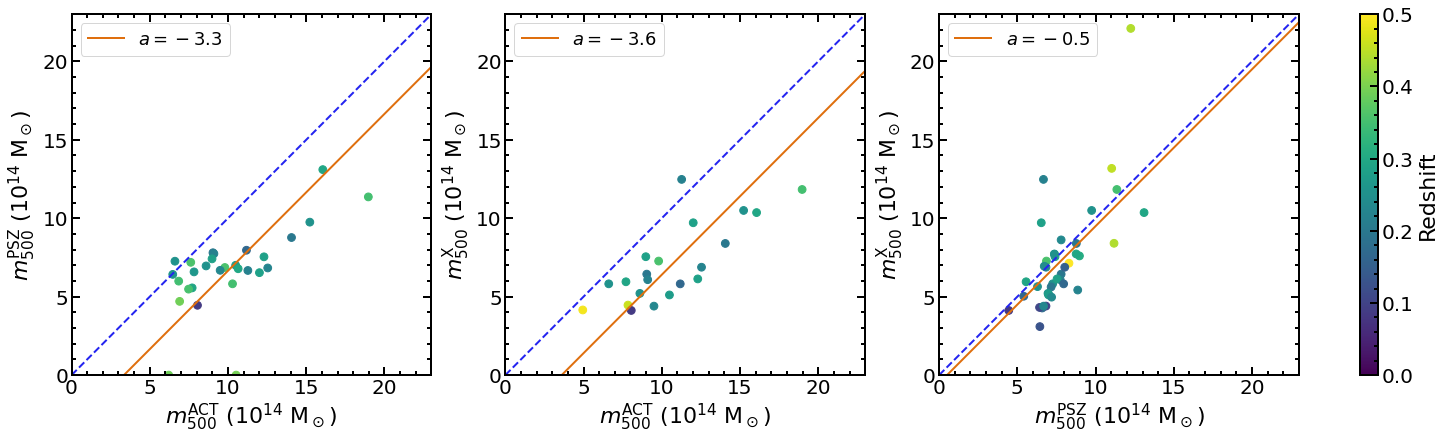

In [89]:
t = np.linspace(0, 25, 10)
fig, axes = plt.subplots(1, 3, figsize=(20,6), constrained_layout=True)
for ax, xname, yname, mask in zip(axes, ('ACT','ACT','PSZ'), ('PSZ','X','X'), (sz, actx, pszx)):
    if np.in1d([xname, yname], ['ACT']).sum() > 0 and sample == 'lowz':
        continue
    if sample == 'evolution':
        x = chances_mcxc[f'm500_{xname}'][mask]
        y = chances_mcxc[f'm500_{yname}'][mask]
    else:
        x = chances_mcxc['m500'][mask]
        y = chances_mcxc['m500_X'][mask]
    z = chances_mcxc['z'][mask]
    pts = ax.scatter(x, y, c=z, vmin=0, vmax=0.5, cmap='viridis', marker='o', s=60)
    ax.plot(t, t, '--')
    # best-fit straight line with slope=1
    fit, cov = curve_fit(line, x, y, p0=(0.3,))
    std = np.std(y - line(x, *fit))
    ax.plot(t, line(t, *fit), '-', label=f'$a={fit[0]:.1f}$')
    xlim = (0, 23) if sample == 'evolution' else (0, 10)
    ax.set(xlabel=fr'$m_{{500}}^\mathrm{{{xname}}}$ ($10^{{14}}$ M$_\odot)$',
           ylabel=fr'$m_{{500}}^\mathrm{{{yname}}}$ ($10^{{14}}$ M$_\odot)$',
           xlim=xlim, ylim=xlim)
    ax.legend()
plt.colorbar(pts, ax=axes, label='Redshift')

A 2d fit:

In [90]:
def plane(xy, a, b, c, d):
    x, y = xy
    return a + b*x + c*y + d*x*y

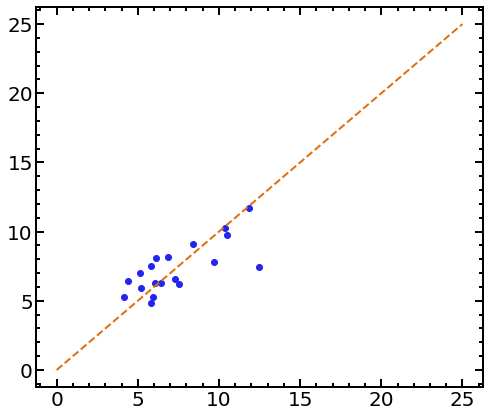

In [92]:
if sample == 'evolution':
    mpsz = chances_mcxc['m500_PSZ']
    mact = chances_mcxc['m500_ACT']
    mx = chances_mcxc['m500_X']
    xfit = [mpsz[xsz], mact[xsz]]
    yfit = mx[xsz]
    fit, cov = curve_fit(plane, xfit, yfit, p0=(2,3,4,2))
    fig, ax = plt.subplots(figsize=(8,7))
    ax.plot(yfit, plane(xfit, *fit), 'o')
    ax.plot(t, t, 'C1--')
    fit

But how many are there with PSZ+X but no ACT?

In [93]:
(inpsz & inx & ~inact).sum()

21

This means we could use the 2d fit to improve the estimate in some Evolution clusters (but not now). The low-z sample has 32 but there are only 2 ACT clusters anyway. So:

## Best masses

**Evolution**

The ACT masses have been (i) Eddington-bias corrected and (ii) indirectly calibrated for SZ bias with weak lensing, so we can take those as reference. adding the appropriate values to either PSZ or X to make them consistent with ACT. If both PSZ and X, but not ACT, are present, we take the PSZ mass.

**Low-z**

The mean difference for low-z, $m_\mathrm{X} = m_\mathrm{PSZ} - 0.6$ is consistent with the zero point found in the evolution sample ($-0.4$), so let's just apply the same correction. We're keeping the ACT masses for the two ACT clusters.

Let's begin by renaming the low-z mass columns for consistency:

In [98]:
if sample == 'lowz':
    #chances_mcxc.rename_column('m500', 'm500_PSZ')
    chances_mcxc['m500_ACT'] = -np.ones(inact.size)
    chances_mcxc.mask['m500_ACT'] = ~inact
    chances_mcxc['m500_ACT'][inact] = chances_mcxc['m500_PSZ'][inact]
    chances_mcxc['m500_PSZ'][inact] = -1

Now we apply the offsets

In [99]:
chances_mcxc['m500_X_corr'] = 3.4 + chances_mcxc['m500_X']
chances_mcxc['m500_PSZ_corr'] = 3.0 + chances_mcxc['m500_PSZ']
chances_mcxc['m500_ACT_corr'] = chances_mcxc['m500_ACT'] # for completeness
chances_mcxc['m500'] = np.zeros(inact.size)
chances_mcxc['m500'][inx] = 3.4 + chances_mcxc['m500_X'][inx]
chances_mcxc['m500'][inpsz] = 3.0 + chances_mcxc['m500_PSZ'][inpsz]
chances_mcxc['m500'][inact] = chances_mcxc['m500_ACT'][inact]

# Radii

We can now calculate the radii:

In [100]:
chances_mcxc['r500'] = conversions.rsph(1e14*chances_mcxc['m500'], chances_mcxc['z'], ref='500c')
chances_mcxc['r500'].value

array([1.16216538, 1.0086094 , 1.2163087 , 1.37267357, 1.35901215,
       1.45269547, 1.43124433, 1.41279015, 1.44145655, 1.6094251 ,
       1.19055204, 1.34570048, 1.37874124, 1.33458004, 1.46079389,
       1.15976497, 1.19587578, 1.26114121, 1.37659235, 1.30362469,
       1.3957207 , 1.49548273, 1.36933952, 1.18801316, 1.13190894,
       1.32434965, 1.32783102, 1.22011814, 1.32407953, 1.32647085,
       1.40732686, 1.41882592, 1.36219109, 1.33183422, 1.30551549,
       1.47908487, 1.45117481, 1.3302088 , 1.17158016, 1.52052492,
       1.4943028 , 1.41279015, 1.35271817, 1.40243212, 1.40937073,
       1.38501678, 1.33031134, 1.60394598, 1.43184513, 1.41356186,
       1.38511291, 1.3439323 , 1.37685884, 1.43192884, 1.36143834,
       1.35956322, 1.59380926, 1.36706015, 1.49480333, 1.46588766,
       1.4414014 , 1.20457261, 1.39004472, 1.347432  , 1.25209565,
       1.28178484, 1.60707127, 1.34452753, 1.3831294 , 1.41327874,
       1.22628078, 1.4344868 , 1.30100007, 1.38767928, 1.44938

In [101]:
for col in chances_mcxc.colnames:
    if 'm500' in col or 'r500' in col:
        chances_mcxc[col].format = '%.2f'
chances_mcxc

CHANCES name,VISTA,Comments,name,index,index_PSZ,hms,dms,z,m500,m500lo,m500hi,hms_PSZ,dms_PSZ,z_PSZ,m500_PSZ,m500lo_PSZ,m500hi_PSZ,index_ACT,ACT_name,hms_ACT,dms_ACT,z_ACT,m500_ACT,m500lo_ACT,m500hi_ACT,MCXC,X-rays,X-ray catalog,L500_X,m500_X,r500_X,m500_X_corr,m500_PSZ_corr,m500_ACT_corr,r500
str19,str4,str17,str19,int64,int64,str10,str9,float64,float64,float64,float64,str10,str9,float64,float64,float64,float64,int64,str19,str10,str9,float64,float64,float64,float64,str12,str18,str12,float64,float64,float64,float64,float64,float64,float64
ACT-CL J0138.0-2155,--,--,ACT-CL J0138.0-2155,1,--,01:38:05.1,-21:55:36,0.338,6.34,1.22,1.41,--,--,--,--,--,--,81,ACT-CL J0138.0-2155,01:38:05.1,-21:55:36,0.34,6.34,1.22,1.41,--,--,--,--,--,--,--,--,6.34,1.16
ACT-CL J1311.0-0310,--,--,ACT-CL J1311.0-0310,40,--,13:11:01.0,-03:10:41,0.491,4.95,0.95,1.09,--,--,--,--,--,--,184,ACT-CL J1311.0-0310,13:11:01.0,-03:10:41,0.49,4.95,0.95,1.09,J1311.0-0310,MACSJ1311.0-0310,MACS,7.240105,4.15,0.95,7.55,--,4.95,1.01
Abell0521,HiLx,MeerKAT,PSZ2 G208.80-30.67,14,37,04:54:08.9,-10:13:22,0.253,6.61,1.34,1.57,04:54:05.0,-10:13:34,0.25,7.26,0.49,0.47,68,ACT-CL J0454.1-1013,04:54:08.9,-10:13:22,0.25,6.61,1.34,1.57,J0454.1-1014,RXCJ0454.1-1014,NORAS/REFLEX,7.44515,5.82,1.17,9.22,10.26,6.61,1.22
Abell0901,HiLx,--,--,--,--,09:56:26.4,-10:04:12,0.163,8.63,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,J0956.4-1004,RXCJ0956.4-1004,NORAS/REFLEX,5.629624,5.23,1.16,8.63,--,--,1.37
Abell0907,HiLx,--,PSZ2 G249.38+33.26,--,--,09:58:24.4,-11:04:08,0.167,8.41,0.37,0.33,09:58:24.4,-11:04:08,0.17,5.41,0.37,0.33,--,--,--,--,--,--,--,--,J0958.3-1103,RXCJ0958.3-1103,NORAS/REFLEX,5.299925,5.03,1.14,8.43,8.41,--,1.36
Abell1300,GCAV,--,PSZ2 G278.58+39.16,34,9,11:31:56.5,-19:54:51,0.308,11.97,0.45,0.46,11:31:56.5,-19:54:51,0.31,8.97,0.45,0.46,--,--,--,--,--,--,--,--,J1131.9-1955,RXCJ1131.9-1955,NORAS/REFLEX,12.461967,7.60,1.25,11.00,11.97,--,1.45
Abell1451,HiLx,--,PSZ2 G288.27+39.97,37,41,12:03:18.1,-21:31:29,0.199,10.16,0.33,0.28,12:03:18.1,-21:31:29,0.2,7.16,0.33,0.28,--,--,--,--,--,--,--,--,J1203.2-2131,RXCJ1203.2-2131,NORAS/REFLEX,6.614737,5.62,1.17,9.02,10.16,--,1.43
Abell3444,P109,--,PSZ2 G266.83+25.08,32,34,10:23:53.1,-27:15:07,0.254,10.37,0.37,0.36,10:23:53.1,-27:15:07,0.25,7.37,0.37,0.36,--,--,--,--,--,--,--,--,J1023.8-2715,RXCJ1023.8-2715,NORAS/REFLEX,11.91962,7.71,1.28,11.11,10.37,--,1.41
AbellS0780,P109,--,PSZ2 G340.94+35.07,51,23,14:59:34.5,-18:10:22,0.236,10.80,0.48,0.45,14:59:34.5,-18:10:22,0.24,7.80,0.48,0.45,--,--,--,--,--,--,--,--,J1459.4-1811,RXCJ1459.4-1811,NORAS/REFLEX,13.967532,8.62,1.34,12.02,10.80,--,1.44


Let's compare the radii from the corrected masses just as a consistency check

In [102]:
def zline(xz, a, b, c=1):
    x, z = xz
    return a + b*z + c*x

In [103]:
for name, mask in zip(('ACT', 'PSZ', 'X'), (inact, inpsz, inx)):
    r500 = conversions.rsph(1e14*chances_mcxc[f'm500_{name}_corr'], chances_mcxc['z'], ref='500c')
    #r500 = np.ma.array(r500, mask=~mask)
    rname = f'r500_{name}_corr'
    if rname in chances_mcxc.colnames:
        chances_mcxc[rname] = r500
    else:
        chances_mcxc.add_column(r500, name=rname)
    if name != 'X':
        r500[mask] = conversions.rsph(1e14*chances_mcxc[f'm500_{name}'][mask], chances_mcxc['z'][mask], ref='500c')
        r500 = np.ma.array(r500, mask=~mask)
        rname = f'r500_{name}'
        if rname in chances_mcxc.colnames:
            chance_mcxc[rname] = r500
        else:
            evol_mcxc.add_column(r500, name=rname)

NameError: name 'evol_mcxc' is not defined

In [ ]:
t = np.linspace(0, 2, 10)
fig, axes = plt.subplots(1, 3, figsize=(20,6), constrained_layout=True)
for ax, xname, yname, mask in zip(axes, ('ACT','ACT','PSZ'), ('PSZ','X','X'), (sz, actx, pszx)):
    x = evol_mcxc[f'r500_{xname}_corr'][mask]
    y = evol_mcxc[f'r500_{yname}_corr'][mask]
    z = evol_mcxc['z'][mask]
    pts = ax.scatter(x, y, c=z, vmin=0, vmax=0.5, cmap='viridis', marker='o', s=60)
    ax.plot(t, t, '--')
    # best-fit straight line with slope=1
    fit, cov = curve_fit(line, x, y, p0=(0.3,))
    std = np.std(y - line(x, *fit))
    ax.plot(t, line(t, *fit), '-', label=f'$a={fit[0]:.2f}$ ($\sigma={std:.2f}$)')
    # best-fit including redshift (not plotting)
    zfit, zcov = curve_fit(zline, [x,z], y, p0=(0.3,0.1))
    zstd = np.std(y - zline([x, z], *zfit))
    print(f'std_z = {zstd:.2f}')
    ax.set(xlabel=fr'$r_{{500}}^\mathrm{{{xname}}}$ (Mpc)',
           ylabel=fr'$r_{{500}}^\mathrm{{{yname}}}$ (Mpc)',
           xlim=(0.8, 2), ylim=(0.8, 2))
    ax.legend()
plt.colorbar(pts, ax=axes, label='Redshift')

Including the redshift does not reduce the scatter.

In [ ]:
evol_mcxc['r500_r'] = 0.15 + evol_mcxc['r500_X']
evol_mcxc['r500_r'][inpsz] = 0.15 + evol_mcxc['r500_PSZ'][inpsz]
evol_mcxc['r500_r'][inact] = evol_mcxc['r500_ACT'][inact]

In [ ]:
rbins = np.arange(1, 1.8, 0.05)
plt.hist(evol_mcxc['r500_r'], rbins, alpha=0.5, label='From radii')
plt.hist(evol_mcxc['r500'], rbins, alpha=0.5, label='From mass')
plt.xlabel('$r_{500}$ (Mpc)')
plt.legend(fontsize=14)

In [ ]:
kpc2arcmin = Planck18.kpc_proper_per_arcmin(evol_mcxc['z'])
d200 = (evol_mcxc['r500'] * u.Mpc / kpc2arcmin).to('arcmin')
plt.hist(d200.value, 20)
plt.xlabel(r'$\theta_{500}$ (arcmin)')

# $r_{200}$

Now let's calculate $r_{200}$:

In [64]:
import astro.constants
import astropy.constants

In [65]:
astro.constants.G

6.6743e-08

In [66]:
astropy.constants.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

Deleted outdated persistence file, no further action needed.


Text(0.5, 0, '$\\theta_{200}$ (arcmin)')

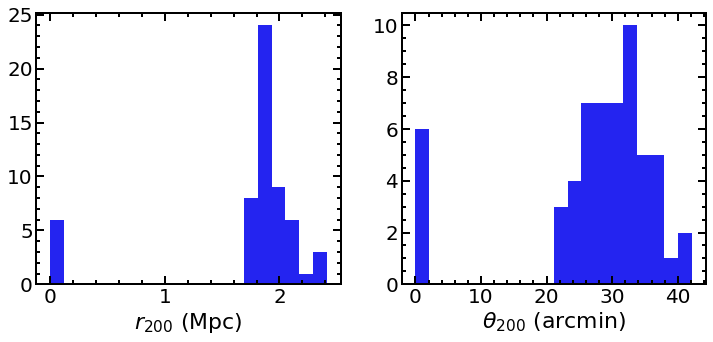

In [72]:
cosmology.fromAstropy(Planck18, sigma8=0.81, ns=0.966)
c = concentration.concentration(1e14*chances_mcxc['m500'], '500c', chances_mcxc['z'], model='ishiyama21')
nfw = NFW(1e14*chances_mcxc['m500'], c, chances_mcxc['z'], overdensity=500, frame='physical', cosmo=Planck18)
m200, c200 = nfw.mdelta(200)
r200 = nfw.rdelta(200)
d200 = (r200*u.Mpc * Planck18.arcsec_per_kpc_proper(chances['z'])).to('arcmin').value
chances_mcxc['m200'] = m200 / 1e14
chances_mcxc['c200'] = c200
chances_mcxc['r200'] = r200
chances_mcxc['d200'] = d200
for col in ('m200','c200','r200','d200'):
    chances_mcxc[col].format = '%.2f'
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].hist(chances_mcxc['r200'], 20)
axes[0].set_xlabel('$r_{200}$ (Mpc)')
axes[1].hist(chances_mcxc['d200'], 20)
axes[1].set_xlabel(r'$\theta_{200}$ (arcmin)')

In [ ]:
chances_mcxc['CHANCES name','ACT_name','X-rays','z','m500','r500','m200','r200','d200'][d200 > 12]

In [73]:
chances_mcxc.write(f'catalogues/chances_clusters_{sample}_r200.txt', format='ascii.fixed_width')